# #Stock data modelling
# cimb

In [1]:
import pandas as pd
import numpy as np
import warnings
from matplotlib import pyplot
from pandas import Series, datetime
from pandas.tools.plotting import scatter_matrix, autocorrelation_plot
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from xgboost import XGBClassifier
import seaborn as sns

/Users/mhafizhussin/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Loading the dataset to a dataframe
cimb_df = pd.read_csv('cimb_clean.csv')

In [3]:
# Check the shape and data types of the dataframe
print(cimb_df.shape)
print(cimb_df.dtypes)

(238, 10)
High          float64
Low           float64
Open          float64
Close         float64
Volume          int64
yhat          float64
us_china      float64
trump         float64
malaysia      float64
target_cls      int64
dtype: object


In [5]:
# Push the Label column to the end of the dataframe
cols = list(cimb_df)
print(cols)

['High', 'Low', 'Open', 'Close', 'Volume', 'yhat', 'us_china', 'trump', 'malaysia', 'target_cls']


2. Data Quality Checks:

Checked the statistics of individual columns in the dataframe. 

In [6]:
print(cimb_df.describe())

             High         Low        Open       Close        Volume  \
count  238.000000  238.000000  238.000000  238.000000  2.380000e+02   
mean     6.026933    5.937143    5.979580    5.982227  1.650123e+07   
std      0.637309    0.626328    0.636682    0.630675  1.095525e+07   
min      4.510000    4.510000    4.510000    4.510000  0.000000e+00   
25%      5.540000    5.460000    5.485000    5.492500  9.683950e+06   
50%      6.165000    6.050000    6.105000    6.105000  1.411605e+07   
75%      6.570000    6.452500    6.507500    6.510000  2.067708e+07   
max      7.080000    7.080000    7.080000    7.080000  7.218620e+07   

             yhat    us_china       trump    malaysia  target_cls  
count  238.000000  238.000000  238.000000  238.000000  238.000000  
mean     5.860721   58.508403   24.815126   44.617647    0.470588  
std      0.657591   15.193079   20.056038    8.488711    0.500186  
min      4.422928   32.857143   10.571429   34.285714    0.000000  
25%      5.382471   

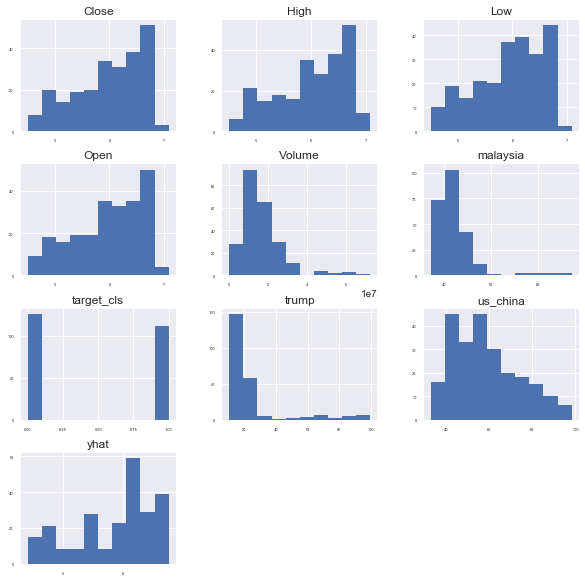

In [7]:
# Plot a histogram for all the columns of the dataframe. This shows the frequency of values in all the columns
sns.set()
cimb_df.hist(sharex = False, sharey = False, xlabelsize = 4, ylabelsize = 4, figsize=(10, 10))
pyplot.show()

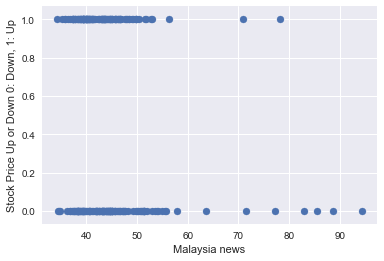

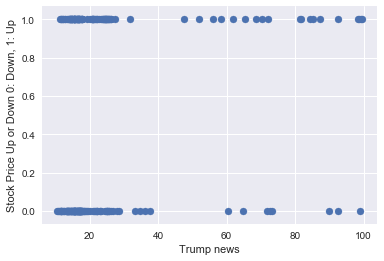

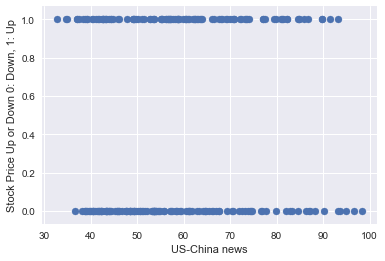

In [9]:
# Check relationship between target with Malaysia, Trump and US-China news
pyplot.scatter(cimb_df['malaysia'], cimb_df['target_cls'])
pyplot.xlabel('Malaysia news')
pyplot.ylabel('Stock Price Up or Down 0: Down, 1: Up')
pyplot.show()
pyplot.scatter(cimb_df['trump'], cimb_df['target_cls'])
pyplot.xlabel('Trump news')
pyplot.ylabel('Stock Price Up or Down 0: Down, 1: Up')
pyplot.show()
pyplot.scatter(cimb_df['us_china'], cimb_df['target_cls'])
pyplot.xlabel('US-China news')
pyplot.ylabel('Stock Price Up or Down 0: Down, 1: Up')
pyplot.show()

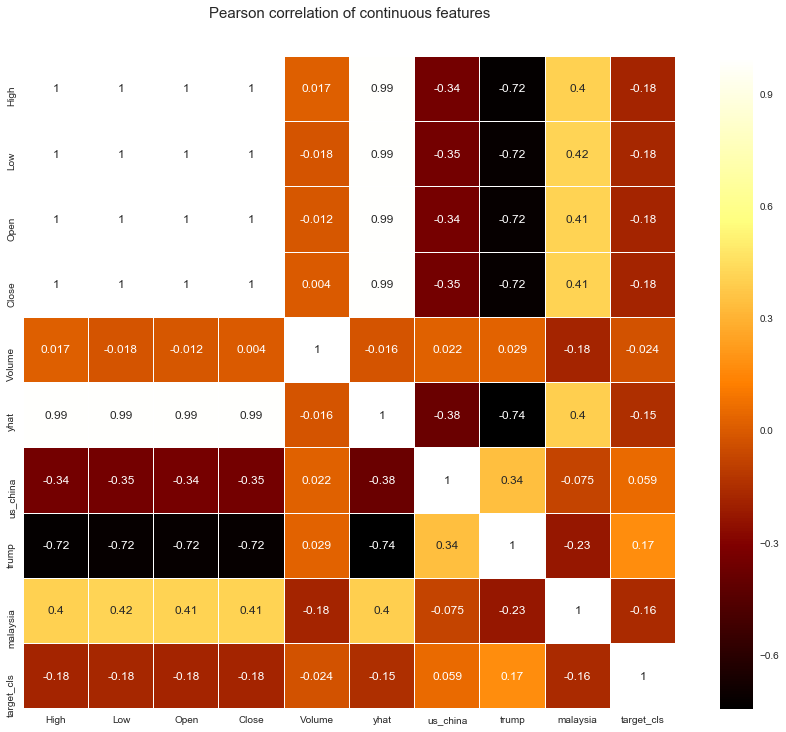

In [10]:
colormap = pyplot.cm.afmhot
pyplot.figure(figsize=(16,12))
pyplot.title('Pearson correlation of continuous features', y=1.05, size=15)
sns.heatmap(cimb_df.corr(),linewidths=0.1,vmax=1.0, square=True, 
            cmap=colormap, linecolor='white', annot=True)
pyplot.show()

#Training
Split the merged dataframe to inputs(X) and outputs(y) 
In our dataset, we have columns High until malaysia as inputs and the target_cls as column output. 

Now, we will split our dataset to training and test samples. Lets train out model on first 80% of the data and test our prediction model on remaining 20% of the data. 

In [11]:
# Separate the dataframe for input(X) and output variables(y)
X = cimb_df.loc[:,'High':'malaysia']
y = cimb_df.loc[:,'target_cls']
# Set the validation size, i.e the test set to 20%
validation_size = 0.20
# Split the dataset to test and train sets
# Split the initial 70% of the data as training set and the remaining 30% data as the testing set
train_size = int(len(X.index) * 0.7)
print(len(y))
print(train_size)
X_train, X_test = X.loc[0:train_size, :], X.loc[train_size: len(X.index), :]
y_train, y_test = y[0:train_size+1], y.loc[train_size: len(X.index)]
print('Observations: %d' % (len(X.index)))
print('X Training Observations: %d' % (len(X_train.index)))
print('X Testing Observations: %d' % (len(X_test.index)))
print('y Training Observations: %d' % (len(y_train)))
print('y Testing Observations: %d' % (len(y_test)))

238
166
Observations: 238
X Training Observations: 167
X Testing Observations: 72
y Training Observations: 167
y Testing Observations: 72


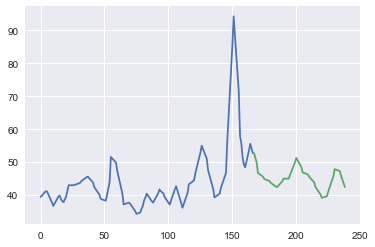

In [12]:
pyplot.plot(X_train['malaysia'])
pyplot.plot([None for i in X_train['malaysia']] + [x for x in X_test['malaysia']])
pyplot.show()

In [13]:
# MOdels
num_folds = 10
scoring = 'accuracy'
# Append the models to the models list
models = []
models.append(('LR' , LogisticRegression()))
models.append(('LDA' , LinearDiscriminantAnalysis()))
models.append(('KNN' , KNeighborsClassifier()))
models.append(('CART' , DecisionTreeClassifier()))
models.append(('NB' , GaussianNB()))
models.append(('SVM' , SVC()))
models.append(('RF' , RandomForestClassifier(n_estimators=50)))
models.append(('XGBoost', XGBClassifier()))

In [14]:
# Evaluate each algorithm for accuracy
results = []
names = []
'''
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=42)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg) '''

for name, model in models:
    clf = model
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accu_score = accuracy_score(y_test, y_pred)
    print(name + ": " + str(accu_score))

/Users/mhafizhussin/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/mhafizhussin/anaconda2/lib/python2.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


LR: 0.5694444444444444
LDA: 0.4027777777777778
KNN: 0.4444444444444444
CART: 0.4444444444444444
NB: 0.5
SVM: 0.5833333333333334
RF: 0.4305555555555556
XGBoost: 0.4305555555555556


In [15]:
# prepare the model LDA
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model_lda = LinearDiscriminantAnalysis()
model_lda.fit(rescaledX, y_train)
# estimate accuracy on validation dataset
rescaledValidationX = scaler.transform(X_test)
predictions = model_lda.predict(rescaledValidationX)
print("accuracy score:")
print(accuracy_score(y_test, predictions))
print("confusion matrix: ")
print(confusion_matrix(y_test, predictions))
print("classification report: ")
print(classification_report(y_test, predictions))

model_xgb = XGBClassifier()
model_xgb.fit(rescaledX, y_train)
# estimate accuracy on validation dataset
rescaledValidationX = scaler.transform(X_test)
predictions = model_xgb.predict(rescaledValidationX)
print("accuracy score:")
print(accuracy_score(y_test, predictions))
print("confusion matrix: ")
print(confusion_matrix(y_test, predictions))
print("classification report: ")
print(classification_report(y_test, predictions))

accuracy score:
0.4027777777777778
confusion matrix: 
[[ 9 32]
 [11 20]]
classification report: 
              precision    recall  f1-score   support

           0       0.45      0.22      0.30        41
           1       0.38      0.65      0.48        31

   micro avg       0.40      0.40      0.40        72
   macro avg       0.42      0.43      0.39        72
weighted avg       0.42      0.40      0.38        72

accuracy score:
0.4444444444444444
confusion matrix: 
[[16 25]
 [15 16]]
classification report: 
              precision    recall  f1-score   support

           0       0.52      0.39      0.44        41
           1       0.39      0.52      0.44        31

   micro avg       0.44      0.44      0.44        72
   macro avg       0.45      0.45      0.44        72
weighted avg       0.46      0.44      0.44        72



/Users/mhafizhussin/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/mhafizhussin/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/mhafizhussin/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  import sys
/Users/mhafizhussin/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:19: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


roc auc is :0.49173878835562546


/Users/mhafizhussin/anaconda2/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:516: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


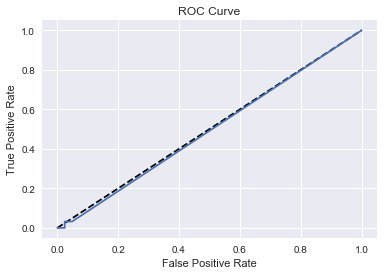

AUC using cross val: [1.         0.83333333 1.         0.6        0.91666667 1.
 0.66666667 0.4        0.58333333 0.7       ]
Mean AUC score is: 0.77


In [16]:
# Generating the ROC curve
y_pred_proba = model_lda.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
print("roc auc is :" + str(roc_auc))
pyplot.plot([0, 1], [0, 1], 'k--')
pyplot.plot(fpr, tpr)
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('ROC Curve')
pyplot.show()

# AUC score using cross validation
kfold_val = KFold(n_splits=num_folds, random_state=42)
auc_score = cross_val_score(model_lda, X_test, y_test, cv=kfold_val, scoring='roc_auc')
print("AUC using cross val: " + str(auc_score))
mean_auc = np.mean(auc_score)
print("Mean AUC score is: " + str(mean_auc))

In [17]:
# Scaling Random Forests
model_rf = RandomForestClassifier(n_estimators=1000)
model_rf.fit(rescaledX, y_train)
# estimate accuracy on validation dataset
rescaledValidationX = scaler.transform(X_test)
predictions = model_rf.predict(rescaledValidationX)
print("accuracy score:")
print(accuracy_score(y_test, predictions))
print("confusion matrix: ")
print(confusion_matrix(y_test, predictions))
print("classification report: ")
print(classification_report(y_test, predictions))

accuracy score:
0.4166666666666667
confusion matrix: 
[[ 8 33]
 [ 9 22]]
classification report: 
              precision    recall  f1-score   support

           0       0.47      0.20      0.28        41
           1       0.40      0.71      0.51        31

   micro avg       0.42      0.42      0.42        72
   macro avg       0.44      0.45      0.39        72
weighted avg       0.44      0.42      0.38        72



/Users/mhafizhussin/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


## PCA transformation

In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(X)
transformed = pca.transform(X)

transformed.shape
print(type(transformed))



<type 'numpy.ndarray'>


In [20]:
pca_df = pd.DataFrame(transformed)

X_train_pca, X_test_pca = pca_df.loc[0:train_size, :], pca_df.loc[train_size: len(X.index), :]

clf = XGBClassifier(n_estimators=500, max_depth=3)
clf.fit(X_train_pca, y_train)
y_pred_pca = clf.predict(X_test_pca)
score = accuracy_score(y_test, y_pred_pca)
print("Score is "+ str(score))

Score is 0.5416666666666666


In [21]:
pca_matrix = confusion_matrix(y_test, y_pred_pca)
pca_report = classification_report(y_test, y_pred_pca)
print("Confusion Matrix: \n" + str(pca_matrix))
print("Classification report: \n" + str(pca_report))

Confusion Matrix: 
[[32  9]
 [24  7]]
Classification report: 
              precision    recall  f1-score   support

           0       0.57      0.78      0.66        41
           1       0.44      0.23      0.30        31

   micro avg       0.54      0.54      0.54        72
   macro avg       0.50      0.50      0.48        72
weighted avg       0.51      0.54      0.50        72



AUC score is 0.5
roc auc is :0.5


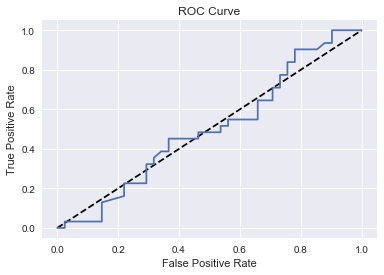

In [22]:
# Generating the ROC curve
y_pred_proba_pca = clf.predict_proba(X_test_pca)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_pca)
roc_auc = auc(fpr, tpr)
print("AUC score is " + str(roc_auc))

# Plot ROC curve
print("roc auc is :" + str(roc_auc))
pyplot.plot([0, 1], [0, 1], 'k--')
pyplot.plot(fpr, tpr)
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('ROC Curve')
pyplot.show()

In [23]:
# XGBoost on Stock Price dataset, Tune n_estimators and max_depth
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import matplotlib

matplotlib.use('Agg')
model = XGBClassifier()
n_estimators = [150, 200, 250, 450, 500, 550, 1000]
max_depth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
print(max_depth)
best_depth = 0
best_estimator = 0
max_score = 0
for n in n_estimators:
    for md in max_depth:
        model = XGBClassifier(n_estimators=n, max_depth=md)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        score = accuracy_score(y_test, y_pred)
        if score > max_score:
            max_score = score
            best_depth = md
            best_estimator = n
        print("Score is " + str(score) + " at depth of " + str(md) + " and estimator " + str(n))
print("Best score is " + str(max_score) + " at depth of " + str(best_depth) + " and estimator of " + str(best_estimator))

/Users/mhafizhussin/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/mhafizhussin/anaconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Users/mhafizhussin/anaconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/mhafizhussin/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/mhafizhussin/anaconda2/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/mhafizhussin/anaconda2/lib/python2.7/s

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Score is 0.5138888888888888 at depth of 1 and estimator 150
Score is 0.5 at depth of 2 and estimator 150
Score is 0.4027777777777778 at depth of 3 and estimator 150
Score is 0.5138888888888888 at depth of 4 and estimator 150
Score is 0.4583333333333333 at depth of 5 and estimator 150
Score is 0.4583333333333333 at depth of 6 and estimator 150
Score is 0.4444444444444444 at depth of 7 and estimator 150
Score is 0.5 at depth of 8 and estimator 150
Score is 0.4722222222222222 at depth of 9 and estimator 150
Score is 0.4305555555555556 at depth of 10 and estimator 150
Score is 0.4722222222222222 at depth of 11 and estimator 150
Score is 0.4722222222222222 at depth of 12 and estimator 150
Score is 0.5138888888888888 at depth of 1 and estimator 200
Score is 0.4583333333333333 at depth of 2 and estimator 200
Score is 0.4583333333333333 at depth of 3 and estimator 200
Score is 0.5 at depth of 4 and estimator 200
Score is 0.4583333333333333 at depth of 5 